In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import matplotlib.pyplot as plt
import os
import pathlib
import random

# Loading Dataset

In [3]:
import shutil

oral_path = "/kaggle/input/oral-cancer-images-for-classification/dataset"
oral_writing_path = "/kaggle/working/clean_dataset"

# Recursively copy the dataset to a writable directory
shutil.copytree(oral_path, oral_writing_path)

'/kaggle/working/clean_dataset'

# Testing the validation of the images

In [4]:
def test_images(directory):
    bad_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                path = os.path.join(root, file)
                try:
                    raw = tf.io.read_file(path)
                    _ = tf.image.decode_jpeg(raw)  # Explicit JPEG decoder
                except Exception as e:
                    print(f"Corrupted or unsupported file: {path}")
                    print(f"Error: {e}")
                    bad_files.append(path)
    return bad_files

bad_images = test_images("/kaggle/working/clean_dataset")  # Change this path
print(f"\nTotal bad images: {len(bad_images)}")

2025-05-16 11:32:37.931273: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Corrupted or unsupported file: /kaggle/working/clean_dataset/normal/193.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/normal/173.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/normal/230.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/normal/156.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP re

# Deleting the bad images 

In [5]:
for file in bad_images:
    os.remove(file)

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 128

In [12]:
oral_dataset = tf.keras.utils.image_dataset_from_directory(
    oral_writing_path,
    seed=12,
    labels="inferred", # Labels from subfolders (e.g., "cat", "dog")
    image_size=(IMG_SIZE,IMG_SIZE),   # Resize images
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 1193 files belonging to 2 classes.


In [13]:
oral_dataset.class_names


['Oral Cancer photos', 'normal']

# visualizing the dataset

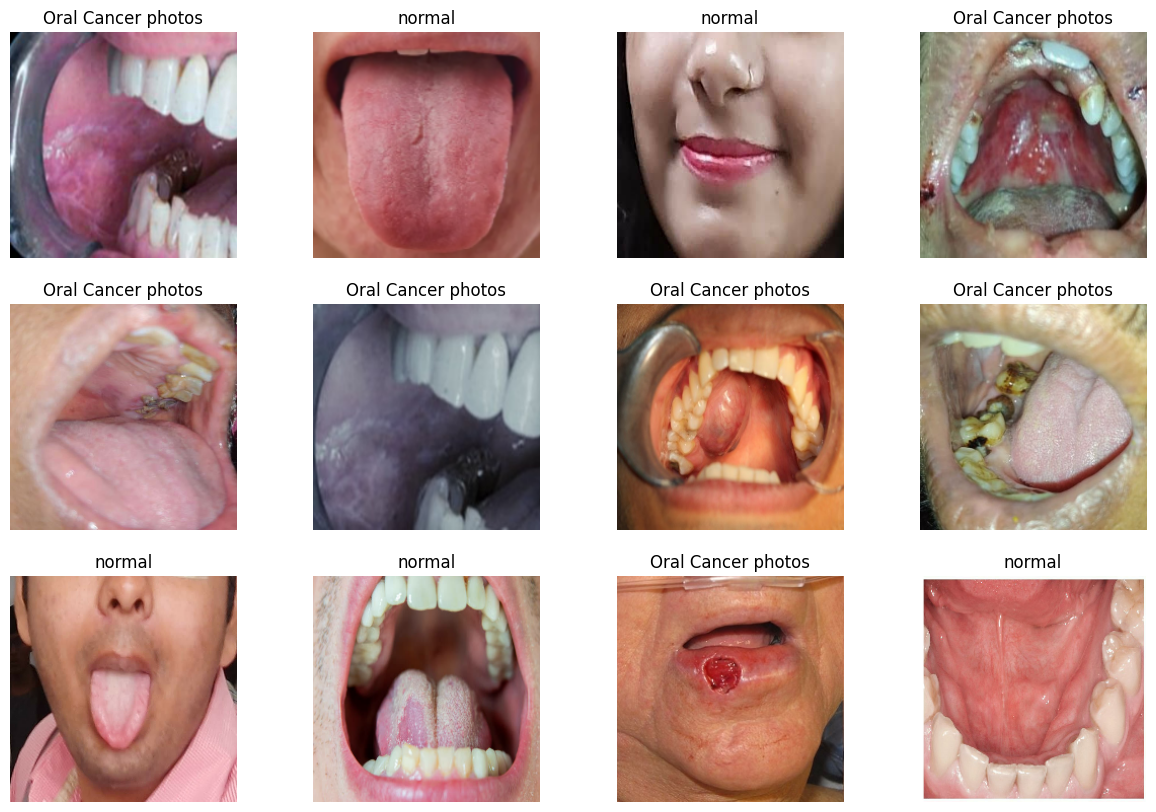

In [14]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in oral_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(oral_dataset.class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in oral_dataset.take(1):
    print(image_batch.shape)


(128, 224, 224, 3)


In [10]:
print("Number of batches =",len(oral_dataset))


Number of batches = 10


# Splitting the dataset

In [50]:
def get_dataset_partitions_tf(ds, train_part=0.8, validation_part=0.1, test_part=0.1, shuffle=True, shuffle_size=10000):
    assert (train_part + test_part + validation_part) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_part * ds_size)
    val_size = int(validation_part * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [51]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(oral_dataset)
print("Number of training batches is",len(train_ds))
print("Number of validation batches is",len(val_ds))
print("Number of testing batches is",len(test_ds))

Number of training batches is 8
Number of validation batches is 1
Number of testing batches is 1


# Normalizing and data augmentation

In [13]:
# Normalizing the image to range from 0 ==> 1 by dividing by 255
resizing_rescaling = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),  
    layers.Rescaling(1./255),                 
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomRotation(factor=0.2),
])

# Our custom model

In [15]:
# Full model
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    resizing_rescaling,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])


In [16]:
# from tensorflow.keras.optimizers import SGD

# optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
model.fit(
    train_ds,
    validation_data=val_ds,
    verbose = 1,
    epochs=100,
    batch_size=BATCH_SIZE
)

Epoch 1/100


I0000 00:00:1747251868.535857      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 993ms/step - accuracy: 0.5710 - loss: 1.9488 - val_accuracy: 0.3750 - val_loss: 1.8458
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6705 - loss: 1.7572 - val_accuracy: 0.4878 - val_loss: 1.7581
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 893ms/step - accuracy: 0.7319 - loss: 1.5760 - val_accuracy: 0.4531 - val_loss: 1.6340
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 886ms/step - accuracy: 0.6860 - loss: 1.4980 - val_accuracy: 0.4766 - val_loss: 1.5831
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step - accuracy: 0.7413 - loss: 1.3662 - val_accuracy: 0.3984 - val_loss: 1.5839
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 873ms/step - accuracy: 0.7515 - loss: 1.2629 - val_accuracy: 0.5078 - val_loss: 1.4919
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 864ms/step - accuracy: 0.7439 - loss: 1.1862 - val_accuracy: 0.4146 - val_loss: 1.6093
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 821ms/step - accuracy: 0.7605 - loss: 1.0947 - val_accuracy: 0.4390 - val_loss: 1.

In [19]:
# Save full model
model.save("my_model.h5")  # or "my_model.keras"

In [52]:
from keras.models import load_model
model = load_model("/kaggle/input/our_custom_model/keras/default/1/my_model.h5")

# Evaluating the model on the test data set

Image to predict :
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
Actual label: Oral Cancer photos
Predicted label: Oral Cancer photos


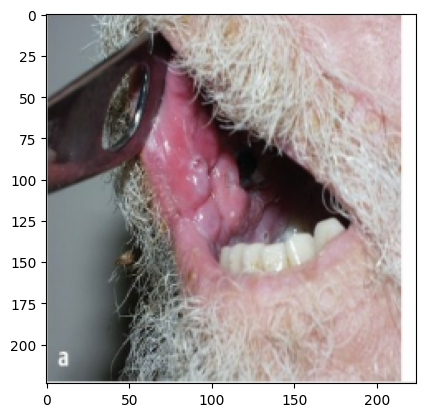

In [53]:
import random 
for image_batch, labels_batch in test_ds.take(1):
    idx = random.randint(0, len(image_batch) - 1)
    image = image_batch[idx].numpy().astype('uint8')
    label = labels_batch[idx].numpy()
    print('Image to predict :')
    plt.imshow(image)
    
    prediction = model.predict(image_batch)
    print('Actual label:',oral_dataset.class_names[label])
    print('Predicted label:',oral_dataset.class_names[np.argmax(prediction[0])])

In [64]:
def predict(model, img, threshold=0.5):
    # Consistent preprocessing
    img_array = tf.image.convert_image_dtype(img, tf.float32)  # 0-255 → 0-1
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Get prediction
    pred_value = model.predict(img_array, verbose=0)[0][0]
    
    # Determine class
    predicted_class = oral_dataset.class_names[int(pred_value > threshold)]
    
    return predicted_class

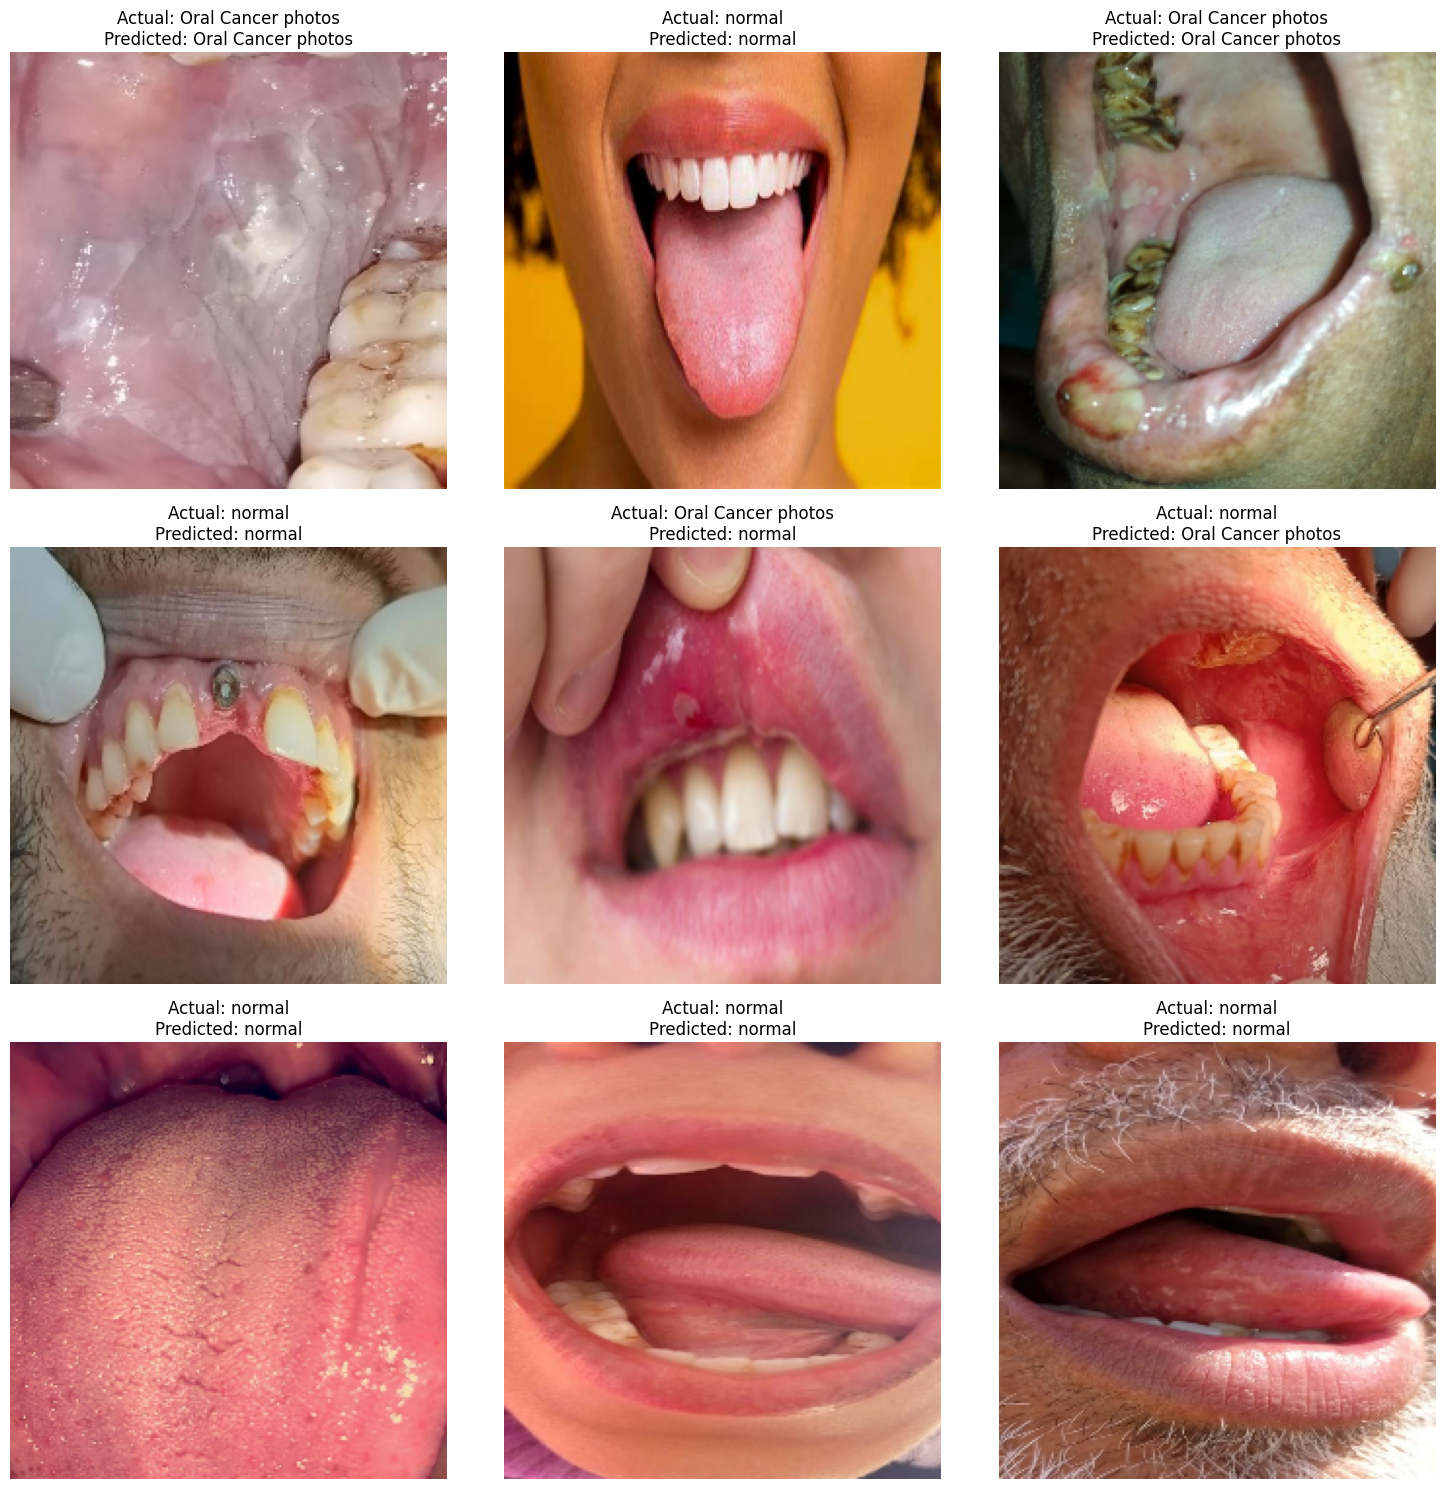

In [65]:
# Prepare test dataset
test_ds = test_ds.unbatch().batch(128).cache()

plt.figure(figsize=(15, 15))
test_samples = list(test_ds.take(3).as_numpy_iterator())

for batch_num, (images, labels) in enumerate(test_samples):
    for i in range(min(9, len(images))):
        # # Randomly select an image from the batch
        # idx = random.randint(0, len(images) - 1)
        
        # Get prediction
        predicted_class = predict(model, images[i])
        actual_class = oral_dataset.class_names[labels[i]]
        
        # Plot
        ax = plt.subplot(3, 3, batch_num * 9 + i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        plt.axis("off")
        
plt.tight_layout()
plt.show()

# The results

In [66]:
model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8359 - loss: 0.4284


[0.42839381098747253, 0.8359375]

In [59]:
# Get predictions from model (batch-wise)
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images,verbose=0)
    
    # For binary classification
    preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy().astype(int))

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=oral_dataset.class_names))

                    precision    recall  f1-score   support

Oral Cancer photos       0.87      0.77      0.82        62
            normal       0.81      0.89      0.85        66

          accuracy                           0.84       128
         macro avg       0.84      0.83      0.83       128
      weighted avg       0.84      0.84      0.84       128



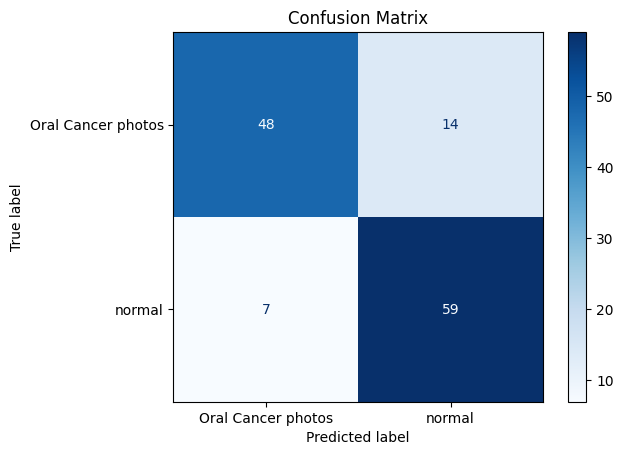

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=oral_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()